How We Compute Basal vs Non-Basal Cells

1:We start with the 3D nuclei mask.

2: We combine all nuclei to rebuild the full organoid shape.

3: We calculate how far every voxel is from the outer surface of the organoid.

4: For each nucleus:

    We look at all its voxels.

    We calculate the median distance to the surface.

    This gives one depth value per cell.

5:We automatically find a cutoff value using Otsu thresholding.

6: Cells that are closer to the surface than the cutoff → Basal.

7: Cells that are deeper inside than the cutoff → Non-Basal.

In [5]:
import nibabel as nib
import numpy as np

def check_nifti_alignment(file1: str, file2: str):
    img1 = nib.load(file1)
    img2 = nib.load(file2)

    print("---- Image 1 ----")
    print("Shape:", img1.shape)
    print("Voxel spacing:", img1.header.get_zooms()[:3])
    #print("Affine:\n", img1.affine)

    print("\n---- Image 2 ----")
    print("Shape:", img2.shape)
    print("Voxel spacing:", img2.header.get_zooms()[:3])
    #print("Affine:\n", img2.affine)

    shape_match = img1.shape == img2.shape
    spacing_match = img1.header.get_zooms()[:3] == img2.header.get_zooms()[:3]
    affine_match = np.allclose(img1.affine, img2.affine)

    print("\n---- Alignment Check ----")
    print("Shape match:", shape_match)
    print("Voxel spacing match:", spacing_match)
    # print("Affine match:", affine_match)

    if shape_match and spacing_match and affine_match:
        print("Images are aligned correctly.")
    else:
        print("❌ Images are NOT aligned. Resampling required.")


check_nifti_alignment(
    "/Users/muhammadsohaib/Downloads/all_data_for_model/10a_day7_d_image.nii.gz",
    "/Users/muhammadsohaib/Downloads/all_data_for_model/10a_day7_d_mask.nii.gz"
)




---- Image 1 ----
Shape: (248, 248, 68)
Voxel spacing: (1.0, 1.0, 1.0)

---- Image 2 ----
Shape: (248, 248, 68)
Voxel spacing: (1.0, 1.0, 1.0)

---- Alignment Check ----
Shape match: True
Voxel spacing match: True
Images are aligned correctly.


In [103]:
import numpy as np
import nibabel as nib
import pandas as pd
from skimage import measure
from scipy.spatial import ConvexHull

def basal_and_intensity_df_hull_vertices_3d(
    nuclei_mask_nifti: str,
    raw_dapi_nifti: str
) -> pd.DataFrame:
    """
    3D ConvexHull method:
    - Basal = nuclei whose centroids are hull vertices
    - Non-basal = others
    - Also computes mean, median, variance from raw DAPI inside each nucleus
    """

    mask_img = nib.load(nuclei_mask_nifti)
    raw_img  = nib.load(raw_dapi_nifti)

    mask = mask_img.get_fdata()
    raw  = raw_img.get_fdata().astype(np.float32)

    if mask.shape != raw.shape:
        raise ValueError("Mask and raw image must have same dimensions.")

    if mask.max() <= 1.0:
        labels = measure.label(mask > 0)
    else:
        labels = mask.astype(np.int32)

    props = measure.regionprops(labels)

    rows = []
    centroids = []

    for p in props:
        coords = p.coords  # (N,3) voxel positions

        # intensity values inside nucleus
        vals = raw[coords[:, 0], coords[:, 1], coords[:, 2]]

        cz, cy, cx = p.centroid
        centroids.append([cz, cy, cx])

        rows.append({
            "cell_id": int(p.label),
            "z": float(cz),
            "y": float(cy),
            "x": float(cx),
            "nucleus_size": int(p.area),
            "mean_intensity": float(np.mean(vals)),
            "median_intensity": float(np.median(vals)),
            "std_intensity": float(np.std(vals, ddof=0)),
        })

    if len(centroids) < 4:
        raise ValueError("Need at least 4 nuclei to compute 3D ConvexHull.")

    centroids = np.asarray(centroids)

    hull = ConvexHull(centroids)
    hull_indices = set(hull.vertices.tolist())

    for i in range(len(rows)):
        rows[i]["cell_type"] = "Basal" if i in hull_indices else "Non-basal"
    print(f"Total cells: {len(rows)}")
    print("--------------------------")
    df = pd.DataFrame(rows).sort_values("cell_id").reset_index(drop=True)
    return df


In [104]:
df = basal_and_intensity_df_hull_vertices_3d(
    nuclei_mask_nifti="/Users/muhammadsohaib/Downloads/all_data_for_model/mask/MCf7-1_mask.nii.gz", #mask
    raw_dapi_nifti="/Users/muhammadsohaib/Downloads/all_data_for_model/image/MCf7-1.nii.gz",
)

print(df["cell_type"].value_counts())
df.to_csv("Calculations.csv", index=False)


Total cells: 32
--------------------------
cell_type
Basal        21
Non-basal    11
Name: count, dtype: int64


In [5]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import measure

def detect_z_axis_from_zooms(img):
    """More reliable than smallest-dimension: choose axis with largest voxel spacing."""
    zooms = img.header.get_zooms()[:3]
    return int(np.argmax(zooms))

def save_all_slice_overlays(
    nuclei_mask_nifti: str,
    raw_dapi_nifti: str,
    df: "pd.DataFrame",
    out_dir: str = "qc_overlays_hull",
    alpha: float = 0.45,
    percentile_vmin: float = 2.0,
    percentile_vmax: float = 99.5,
    use_zooms_for_z: bool = True,
):
    os.makedirs(out_dir, exist_ok=True)

    nuc_img = nib.load(nuclei_mask_nifti)
    raw_img = nib.load(raw_dapi_nifti)

    nuclei = np.asanyarray(nuc_img.dataobj) > 0
    raw    = np.asanyarray(raw_img.dataobj).astype(np.float32)

    if nuclei.shape != raw.shape:
        raise ValueError(f"Mask and raw must match. mask={nuclei.shape}, raw={raw.shape}")

    labels = measure.label(nuclei)

    z_axis = detect_z_axis_from_zooms(nuc_img) if use_zooms_for_z else int(np.argmin(labels.shape))

    # Map cell_id -> type
    type_map = dict(zip(df["cell_id"].astype(int), df["cell_type"].astype(str)))

    n_slices = labels.shape[z_axis]
    print(f"Saving {n_slices} overlays to: {out_dir} | z_axis={z_axis}")

    for zi in range(n_slices):
        raw2d = np.take(raw, zi, axis=z_axis)
        lab2d = np.take(labels, zi, axis=z_axis)

        basal_mask = np.zeros_like(lab2d, dtype=bool)
        non_mask   = np.zeros_like(lab2d, dtype=bool)

        ids = np.unique(lab2d)
        ids = ids[ids > 0]

        for cid in ids:
            cid = int(cid)
            t = type_map.get(cid, None)
            if t == "Basal":
                basal_mask |= (lab2d == cid)
            elif t == "Non-basal":
                non_mask |= (lab2d == cid)

        # contrast
        vmin, vmax = np.percentile(raw2d, (percentile_vmin, percentile_vmax))

        fig = plt.figure(figsize=(7, 7))
        plt.imshow(raw2d, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")

        # Basal (red)
        plt.imshow(
            np.ma.masked_where(~basal_mask, basal_mask),
            cmap="autumn",
            alpha=alpha,
            origin="lower"
        )
        # Non-basal (blue)
        plt.imshow(
            np.ma.masked_where(~non_mask, non_mask),
            cmap="winter",
            alpha=alpha,
            origin="lower"
        )

        plt.title(f"Slice {zi}/{n_slices-1} | z_axis={z_axis}")
        plt.axis("off")
        plt.tight_layout()

        out_path = os.path.join(out_dir, f"overlay_{zi:04d}.png")
        plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0.02)
        plt.close(fig)

    print("Done.")


def show_montage(
    nuclei_mask_nifti: str,
    raw_dapi_nifti: str,
    df: "pd.DataFrame",
    step: int = 5,
    cols: int = 6,
    alpha: float = 0.45,
    use_zooms_for_z: bool = True,
):
    """Quick visual check: shows every `step` slice in one grid."""
    nuc_img = nib.load(nuclei_mask_nifti)
    raw_img = nib.load(raw_dapi_nifti)

    nuclei = np.asanyarray(nuc_img.dataobj) > 0
    raw    = np.asanyarray(raw_img.dataobj).astype(np.float32)
    labels = measure.label(nuclei)

    z_axis = detect_z_axis_from_zooms(nuc_img) if use_zooms_for_z else int(np.argmin(labels.shape))
    type_map = dict(zip(df["cell_id"].astype(int), df["cell_type"].astype(str)))

    z_slices = labels.shape[z_axis]
    slice_ids = list(range(0, z_slices, step))
    rows = int(np.ceil(len(slice_ids) / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, zi in enumerate(slice_ids, start=1):
        raw2d = np.take(raw, zi, axis=z_axis)
        lab2d = np.take(labels, zi, axis=z_axis)

        basal_mask = np.zeros_like(lab2d, dtype=bool)
        non_mask   = np.zeros_like(lab2d, dtype=bool)

        ids = np.unique(lab2d)
        ids = ids[ids > 0]
        for cid in ids:
            t = type_map.get(int(cid), None)
            if t == "Basal":
                basal_mask |= (lab2d == cid)
            elif t == "Non-basal":
                non_mask |= (lab2d == cid)

        vmin, vmax = np.percentile(raw2d, (2, 99.5))

        ax = plt.subplot(rows, cols, i)
        ax.imshow(raw2d, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
        ax.imshow(np.ma.masked_where(~basal_mask, basal_mask), cmap="autumn", alpha=alpha, origin="lower")
        ax.imshow(np.ma.masked_where(~non_mask, non_mask), cmap="winter", alpha=alpha, origin="lower")
        ax.set_title(f"{zi}", fontsize=10)
        ax.axis("off")

    plt.suptitle(f"Montage (step={step}) | z_axis={z_axis}", y=0.98)
    plt.tight_layout()
    plt.show()


Saving 213 overlays to: qc_overlays_hull | z_axis=0
Done.


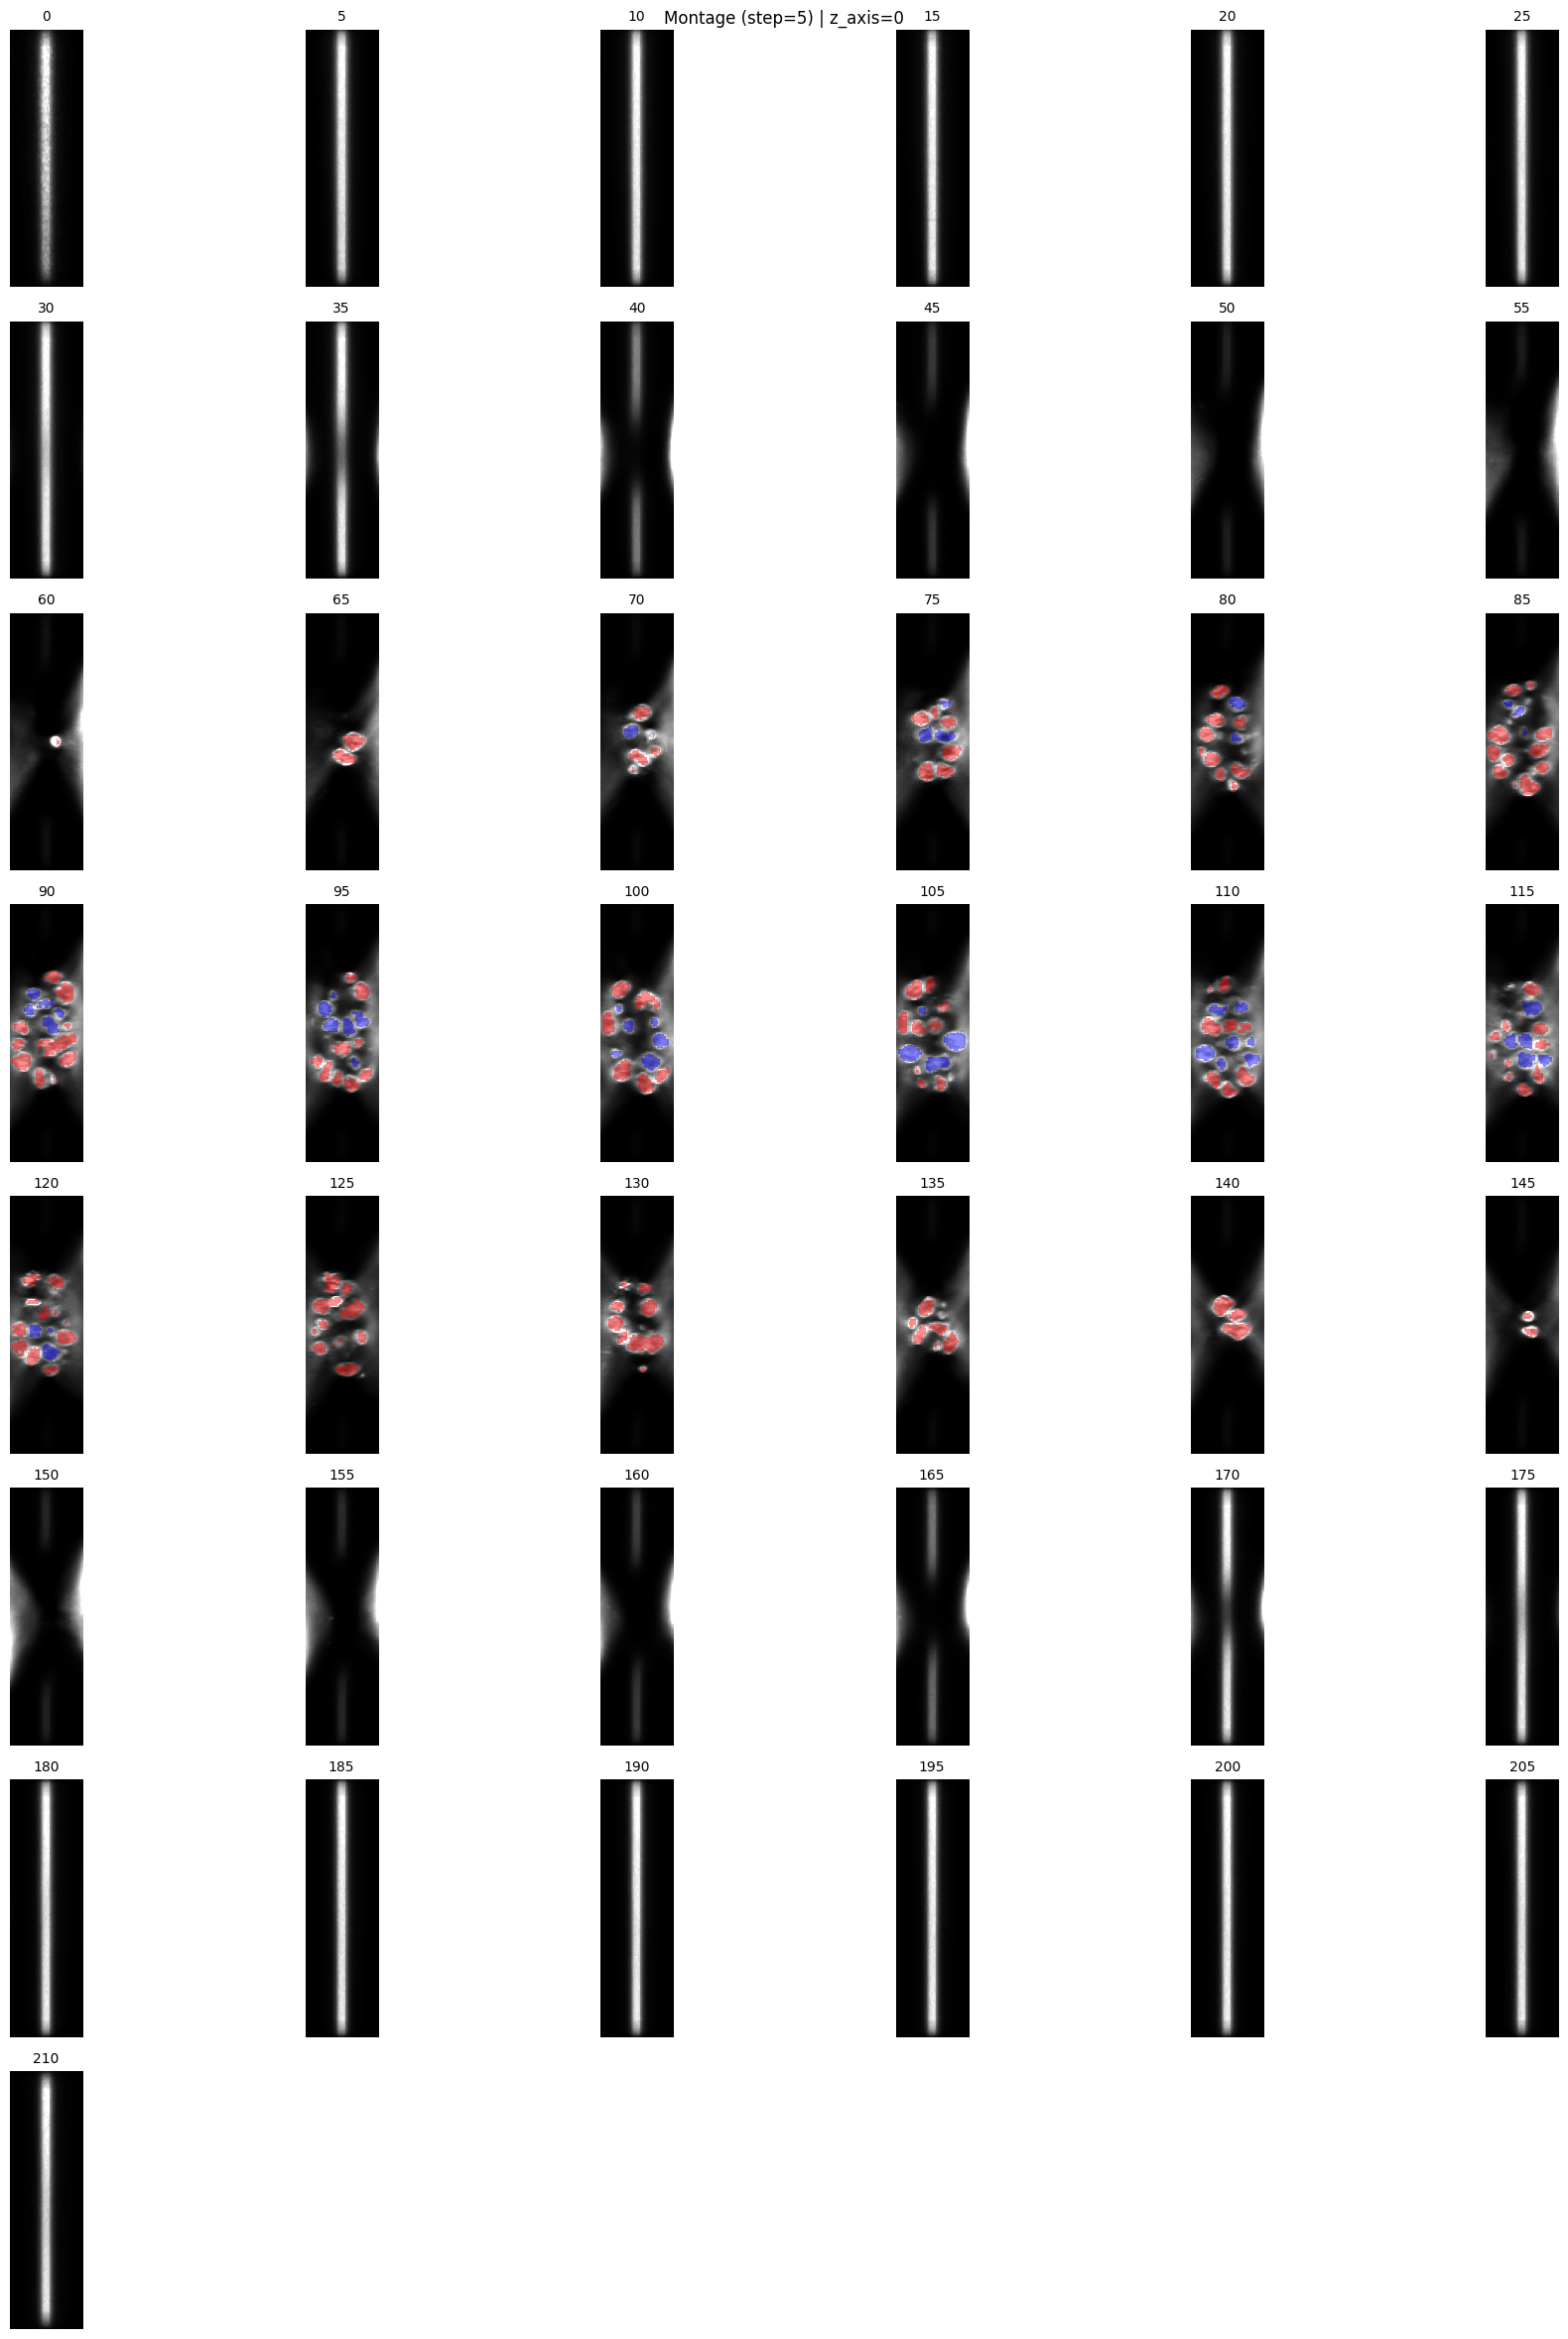

In [6]:
save_all_slice_overlays(
    nuclei_mask_nifti="/Users/muhammadsohaib/Downloads/all_data_for_model/mask/MCf7-1_mask.nii.gz",
    raw_dapi_nifti="/Users/muhammadsohaib/Downloads/all_data_for_model/image/MCf7-1.nii.gz",
    df=df,
    out_dir="qc_overlays_hull",
)

show_montage(
    "/Users/muhammadsohaib/Downloads/all_data_for_model/mask/MCf7-1_mask.nii.gz",
    "/Users/muhammadsohaib/Downloads/all_data_for_model/image/MCf7-1.nii.gz",
    df=df,
    step=5,
    cols=6
)


Auto axis = 2 shape = (213, 177, 50)
Total cells: 32
cell_type
Basal        21
Non-basal    11
Name: count, dtype: int64
Saved: Calculations.csv


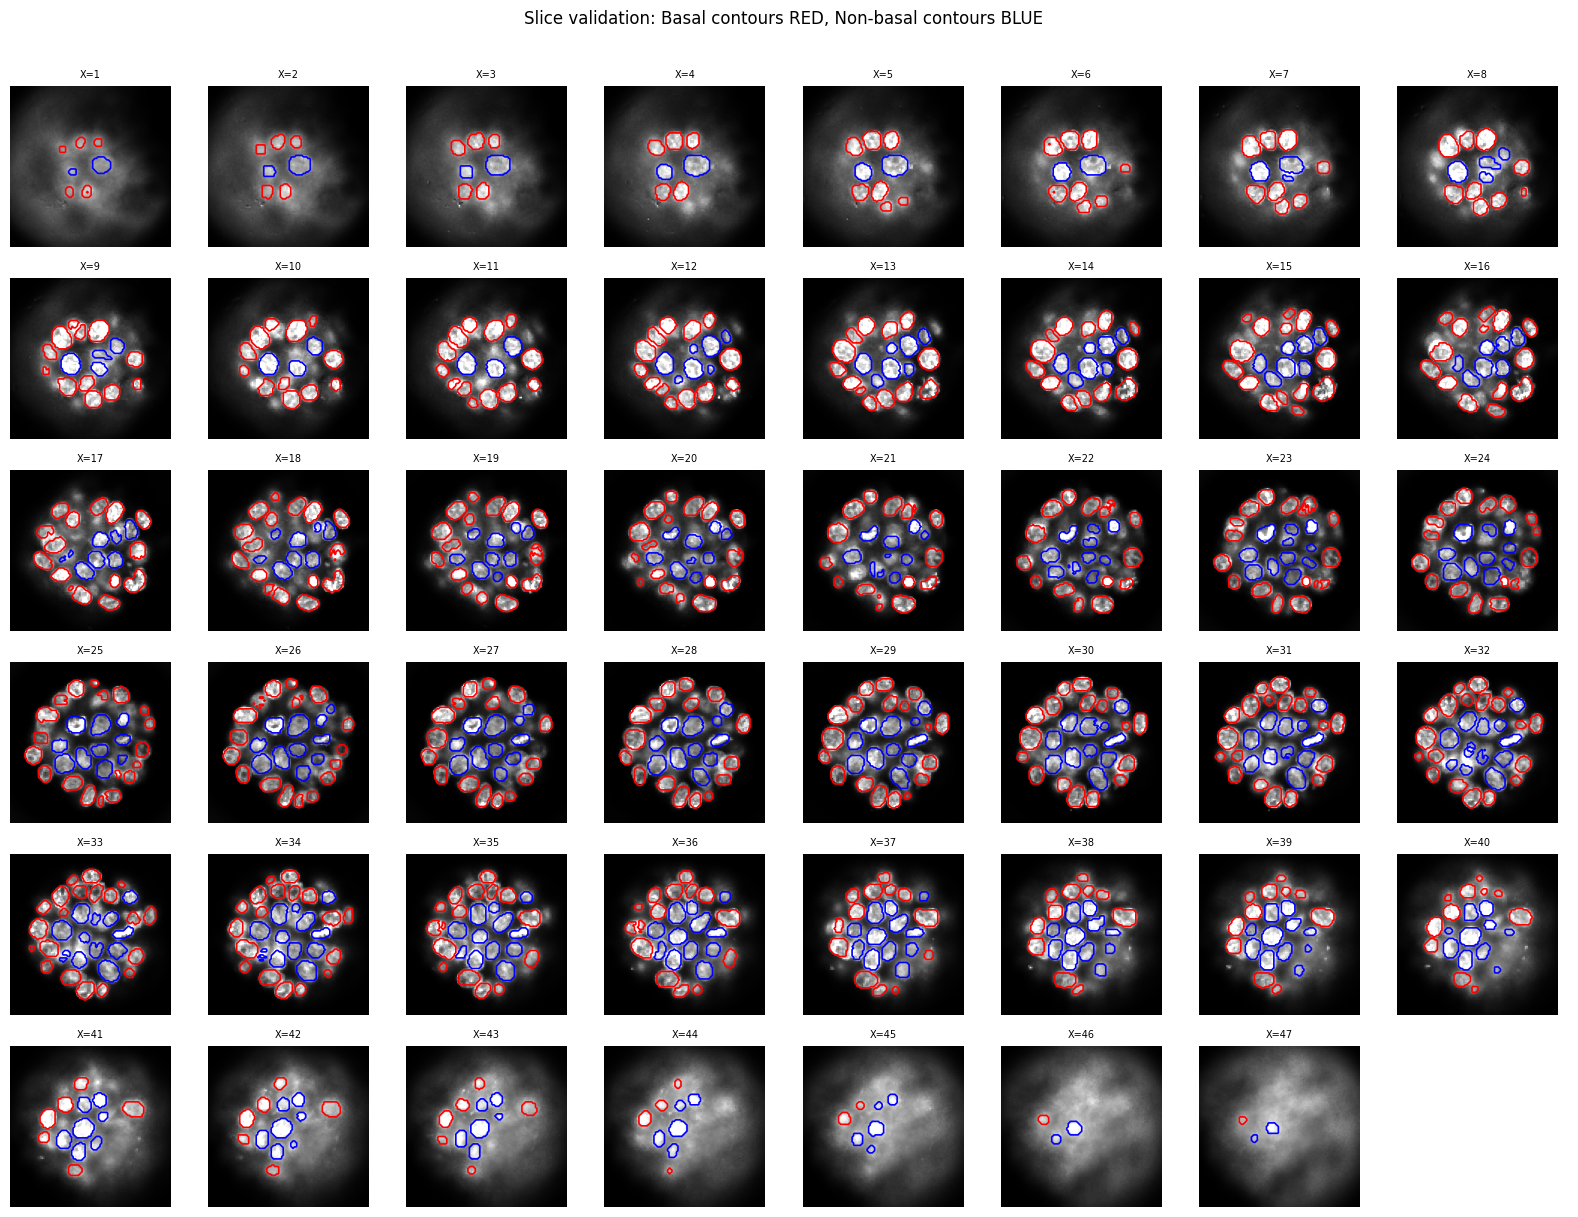

In [66]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

from skimage import measure, morphology
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi


# ----------------------------
# Utils
# ----------------------------
def detect_z_axis(img: nib.Nifti1Image) -> int:
    """Pick the axis that is most likely the 'stack' axis."""
    zooms = np.array(img.header.get_zooms()[:3], dtype=float)
    shape = np.array(img.shape[:3], dtype=int)

    z_by_zooms = int(np.argmax(zooms))   # largest voxel spacing often = z
    z_by_shape = int(np.argmin(shape))   # smallest dimension often = z

    if np.allclose(zooms, zooms[0], rtol=0.05, atol=0.05):
        return z_by_shape
    return z_by_zooms


def get_labels(mask: np.ndarray) -> np.ndarray:
    if mask.max() <= 1:
        return measure.label(mask > 0)
    return mask.astype(np.int32)


def compute_df_centroids_intensity(labels: np.ndarray, raw: np.ndarray) -> pd.DataFrame:
    rows = []
    for p in measure.regionprops(labels):
        coords = p.coords
        vals = raw[coords[:, 0], coords[:, 1], coords[:, 2]]

        cz, cy, cx = p.centroid
        rows.append({
            "cell_id": int(p.label),
            "z": float(cz), "y": float(cy), "x": float(cx),
            "nucleus_size": int(p.area),
            "mean_intensity": float(np.mean(vals)),
            "median_intensity": float(np.median(vals)),
            "std_intensity": float(np.std(vals, ddof=0)),
        })
    return pd.DataFrame(rows).sort_values("cell_id").reset_index(drop=True)


# ----------------------------
# Robust organoid-body from nuclei (NO RAW thresholding)
# ----------------------------
def build_body_from_nuclei_stable(labels: np.ndarray) -> np.ndarray:
    nuclei = labels > 0
    props = measure.regionprops(labels)
    if len(props) == 0:
        raise ValueError("No nuclei found in mask.")

    vols = np.array([p.area for p in props], dtype=np.float32)
    r_med = float(np.median((3.0 * vols / (4.0 * np.pi)) ** (1.0 / 3.0)))  # vox radius approx

    # connect nuclei -> single blob organoid
    connect_radius = int(np.clip(1.2 * r_med, 3, 10))
    close_radius   = int(np.clip(1.8 * r_med, 4, 14))

    body = morphology.binary_dilation(nuclei, morphology.ball(connect_radius))
    body = morphology.binary_closing(body, morphology.ball(close_radius))
    body = ndi.binary_fill_holes(body)

    # keep largest CC only
    cc = measure.label(body)
    sizes = np.bincount(cc.ravel())
    sizes[0] = 0
    body = (cc == int(np.argmax(sizes)))

    return body


def surface_points_from_body(body: np.ndarray, max_points: int = 8000) -> np.ndarray:
    """Return (N,3) points on the surface for plotting (sampled)."""
    er = morphology.binary_erosion(body, morphology.ball(1))
    surf = body & (~er)
    pts = np.argwhere(surf)
    if pts.shape[0] == 0:
        return pts
    if pts.shape[0] > max_points:
        idx = np.random.choice(pts.shape[0], size=max_points, replace=False)
        pts = pts[idx]
    return pts


# ----------------------------
# Basal classification by depth-to-surface (AUTO)
# ----------------------------
def basal_df_surface_auto(mask_path: str, raw_path: str) -> pd.DataFrame:
    mask_img = nib.load(mask_path)
    raw_img  = nib.load(raw_path)

    mask = np.asanyarray(mask_img.dataobj)
    raw  = np.asanyarray(raw_img.dataobj).astype(np.float32)

    if mask.shape != raw.shape:
        raise ValueError(f"Shape mismatch: mask={mask.shape} raw={raw.shape}")

    labels = get_labels(mask)
    df = compute_df_centroids_intensity(labels, raw)

    axis = detect_z_axis(mask_img)
    print("Auto axis =", axis, "shape =", labels.shape)

    # organoid body from nuclei ONLY
    body = build_body_from_nuclei_stable(labels)

    # depth-to-surface (distance to outside) in VOXELS (inside body > 0)
    depth_vox = ndi.distance_transform_edt(body.astype(np.uint8))

    # per-cell depth = MIN depth among nucleus voxels (most conservative for boundary)
    depths = {}
    for p in measure.regionprops(labels):
        coords = p.coords
        # depths[int(p.label)] = float(np.min(depth_vox[coords[:, 0], coords[:, 1], coords[:, 2]]))
        depths[int(p.label)] = float(np.median(depth_vox[coords[:,0], coords[:,1], coords[:,2]]))

    df["depth_to_surface_vox"] = df["cell_id"].astype(int).map(depths).astype(float)

    # --- AUTO cutoff ---
    d = df["depth_to_surface_vox"].values
    if np.allclose(d, d[0]):
        # if totally flat, something is wrong (should not happen with stable body)
        cutoff = float(d[0])
        print("WARNING: depth values are flat. cutoff =", cutoff)
    else:
        # Otsu works well on "two populations": boundary (small d) vs interior (large d)
        try:
            cutoff = float(threshold_otsu(d))
        except Exception:
            cutoff = float(np.percentile(d, 35))  # fallback

    df["cell_type"] = np.where(df["depth_to_surface_vox"] <= cutoff, "Basal", "Non-basal")

    print("Total cells:", len(df))
    print(df["cell_type"].value_counts())
    # print("Auto cutoff (depth_to_surface_vox):", cutoff)
    # print("Depth range (vox):", float(d.min()), "to", float(d.max()))

    return df, labels, raw, body, axis


# ----------------------------
# Visualization
# ----------------------------
def plot_depth_hist(df: pd.DataFrame):
    plt.figure(figsize=(5, 3))
    plt.hist(df["depth_to_surface_vox"].values, bins=15)
    plt.title("Depth-to-surface histogram (vox)")
    plt.xlabel("depth_to_surface_vox")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


def plot_3d_scatter_with_surface(df: pd.DataFrame, body: np.ndarray):
    basal = df[df["cell_type"] == "Basal"]
    nonb  = df[df["cell_type"] == "Non-basal"]

    surf_pts = surface_points_from_body(body, max_points=8000)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")

    if surf_pts.shape[0] > 0:
        ax.scatter(surf_pts[:, 2], surf_pts[:, 1], surf_pts[:, 0], s=1, alpha=0.12, color="gray")

    ax.scatter(nonb["x"], nonb["y"], nonb["z"], s=18, alpha=0.7, color="blue", label="Non-basal")
    ax.scatter(basal["x"], basal["y"], basal["z"], s=70, alpha=0.95, color="red", label="Basal")

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title("Basal (RED) vs Non-basal (BLUE) + organoid surface")
    ax.legend()
    plt.tight_layout()
    plt.show()


def display_slice_grid_contours(mask_labels: np.ndarray,
                                raw: np.ndarray,
                                df: pd.DataFrame,
                                axis: int,
                                every: int = 1,
                                ncols: int = 8,
                                size: float = 2.0,
                                pad: int = 10):
    """
    Slice-wise validation:
    - basal contours RED
    - non-basal contours BLUE
    """
    organoid = mask_labels > 0
    coords = np.argwhere(organoid)
    mins = np.maximum(coords.min(axis=0) - pad, 0)
    maxs = np.minimum(coords.max(axis=0) + 1 + pad, np.array(mask_labels.shape))

    type_map = dict(zip(df["cell_id"].astype(int), df["cell_type"]))
    vmin, vmax = np.percentile(raw, 2), np.percentile(raw, 99.5)

    idxs = list(range(0, mask_labels.shape[axis], every))
    idxs = [k for k in idxs if np.any(np.take(organoid, k, axis=axis))]

    nrows = int(np.ceil(len(idxs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size))
    axes = np.array(axes).reshape(-1)

    title_prefix = "Z=" if axis == 0 else ("Y=" if axis == 1 else "X=")

    for i, k in enumerate(idxs):
        ax = axes[i]

        sl = [slice(mins[0], maxs[0]), slice(mins[1], maxs[1]), slice(mins[2], maxs[2])]
        sl[axis] = k

        img2d = raw[tuple(sl)]
        lab2d = mask_labels[tuple(sl)]

        ax.imshow(img2d, cmap="gray", vmin=vmin, vmax=vmax)

        # draw ONLY contours, colored by class
        ids = np.unique(lab2d)
        for cid in ids:
            if cid == 0:
                continue
            col = "red" if type_map.get(int(cid), "Non-basal") == "Basal" else "blue"
            ax.contour((lab2d == cid), levels=[0.5], linewidths=1.2, colors=[col])

        ax.set_title(f"{title_prefix}{k}", fontsize=7)
        ax.axis("off")

    for j in range(len(idxs), len(axes)):
        axes[j].axis("off")

    plt.suptitle("Slice validation: Basal contours RED, Non-basal contours BLUE", y=1.01, fontsize=12)
    plt.tight_layout()
    plt.show()


# ----------------------------
# One-call pipeline (ONLY TWO FILES)
# ----------------------------
def run_basal_pipeline(mask_path: str, raw_path: str, out_csv: str = "Calculations.csv"):
    df, labels, raw, body, axis = basal_df_surface_auto(mask_path, raw_path)

    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # plot_depth_hist(df)
    # plot_3d_scatter_with_surface(df, body)
    display_slice_grid_contours(labels, raw, df, axis=axis, every=1, ncols=8, size=2.0, pad=10)

    return df


# =========================
# RUN
# =========================
mask_path = "/Users/muhammadsohaib/Downloads/all_data_for_model/mask/MCf7-1_mask.nii.gz"
raw_path  = "/Users/muhammadsohaib/Downloads/all_data_for_model/image/MCf7-1.nii.gz"

df = run_basal_pipeline(mask_path, raw_path)

Auto axis = 2 shape = (248, 248, 63)
Total cells: 8
cell_type
Basal        6
Non-basal    2
Name: count, dtype: int64
Saved: Calculations.csv


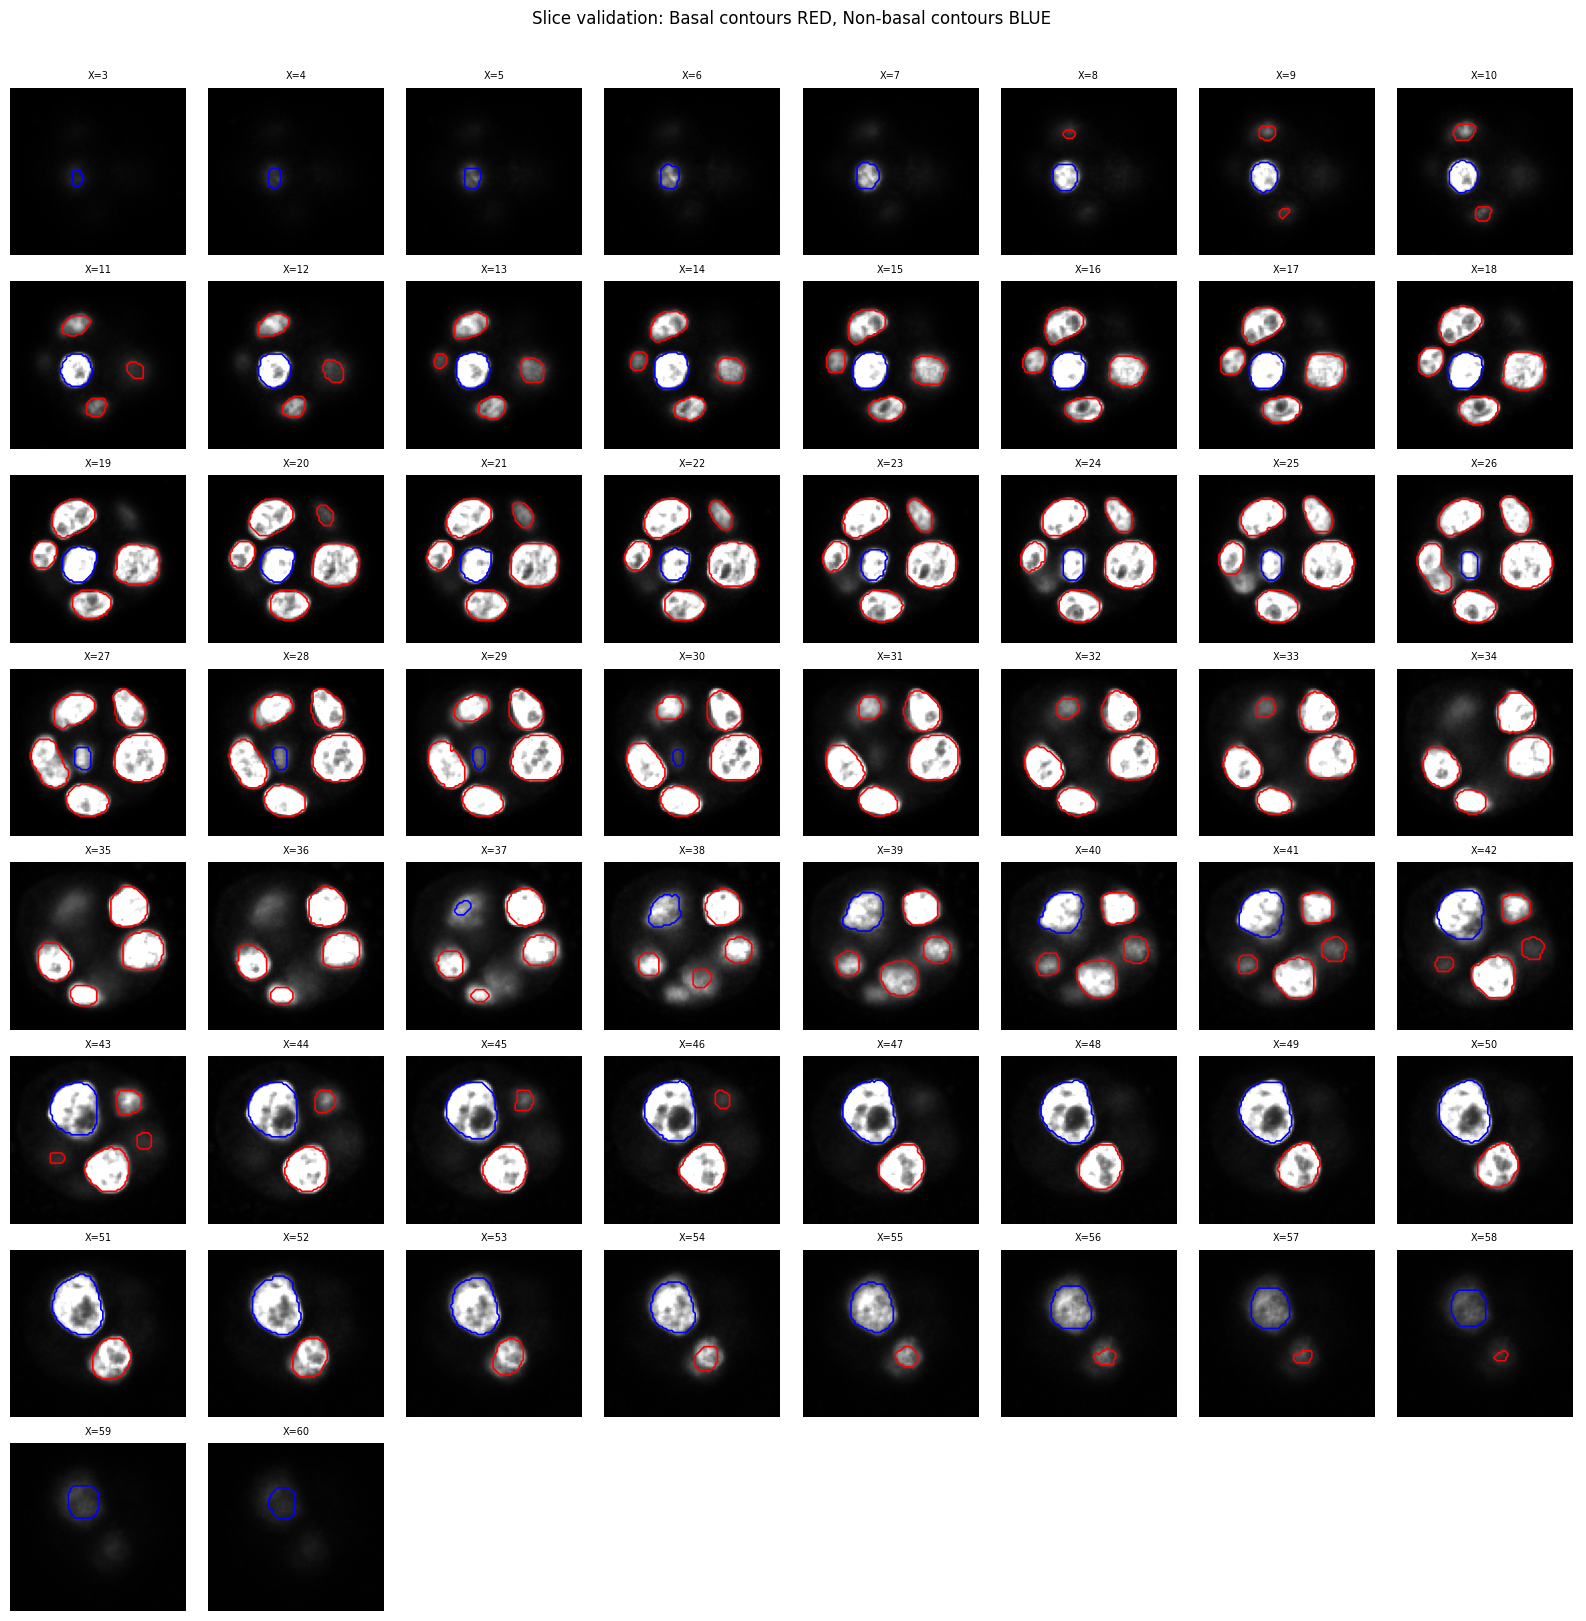

In [70]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

from skimage import measure, morphology
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi


# ----------------------------
# Utils
# ----------------------------
def detect_z_axis(img: nib.Nifti1Image) -> int:
    """Pick the axis that is most likely the 'stack' axis."""
    zooms = np.array(img.header.get_zooms()[:3], dtype=float)
    shape = np.array(img.shape[:3], dtype=int)

    z_by_zooms = int(np.argmax(zooms))   # largest voxel spacing often = z
    z_by_shape = int(np.argmin(shape))   # smallest dimension often = z

    if np.allclose(zooms, zooms[0], rtol=0.05, atol=0.05):
        return z_by_shape
    return z_by_zooms


def get_labels(mask: np.ndarray) -> np.ndarray:
    if mask.max() <= 1:
        return measure.label(mask > 0)
    return mask.astype(np.int32)


def compute_df_centroids_intensity(labels: np.ndarray, raw: np.ndarray) -> pd.DataFrame:
    rows = []
    for p in measure.regionprops(labels):
        coords = p.coords
        vals = raw[coords[:, 0], coords[:, 1], coords[:, 2]]

        cz, cy, cx = p.centroid
        rows.append({
            "cell_id": int(p.label),
            "z": float(cz), "y": float(cy), "x": float(cx),
            "nucleus_size": int(p.area),
            "mean_intensity": float(np.mean(vals)),
            "median_intensity": float(np.median(vals)),
            "std_intensity": float(np.std(vals, ddof=0)),
        })
    return pd.DataFrame(rows).sort_values("cell_id").reset_index(drop=True)


# ----------------------------
# Robust organoid-body from nuclei (NO RAW thresholding)
# ----------------------------
def build_body_from_nuclei_stable(labels: np.ndarray) -> np.ndarray:
    nuclei = labels > 0
    props = measure.regionprops(labels)
    if len(props) == 0:
        raise ValueError("No nuclei found in mask.")

    vols = np.array([p.area for p in props], dtype=np.float32)
    r_med = float(np.median((3.0 * vols / (4.0 * np.pi)) ** (1.0 / 3.0)))  # vox radius approx

    # connect nuclei -> single blob organoid
    connect_radius = int(np.clip(1.2 * r_med, 3, 10))
    close_radius   = int(np.clip(1.8 * r_med, 4, 14))

    body = morphology.binary_dilation(nuclei, morphology.ball(connect_radius))
    body = morphology.binary_closing(body, morphology.ball(close_radius))
    body = ndi.binary_fill_holes(body)

    # keep largest CC only
    cc = measure.label(body)
    sizes = np.bincount(cc.ravel())
    sizes[0] = 0
    body = (cc == int(np.argmax(sizes)))

    return body


def surface_points_from_body(body: np.ndarray, max_points: int = 8000) -> np.ndarray:
    """Return (N,3) points on the surface for plotting (sampled)."""
    er = morphology.binary_erosion(body, morphology.ball(1))
    surf = body & (~er)
    pts = np.argwhere(surf)
    if pts.shape[0] == 0:
        return pts
    if pts.shape[0] > max_points:
        idx = np.random.choice(pts.shape[0], size=max_points, replace=False)
        pts = pts[idx]
    return pts


# ----------------------------
# Basal classification by depth-to-surface (AUTO)
# ----------------------------
def basal_df_surface_auto(mask_path: str, raw_path: str) -> pd.DataFrame:
    mask_img = nib.load(mask_path)
    raw_img  = nib.load(raw_path)

    mask = np.asanyarray(mask_img.dataobj)
    raw  = np.asanyarray(raw_img.dataobj).astype(np.float32)

    if mask.shape != raw.shape:
        raise ValueError(f"Shape mismatch: mask={mask.shape} raw={raw.shape}")

    labels = get_labels(mask)
    df = compute_df_centroids_intensity(labels, raw)

    axis = detect_z_axis(mask_img)
    print("Auto axis =", axis, "shape =", labels.shape)

    # organoid body from nuclei ONLY
    body = build_body_from_nuclei_stable(labels)

    # depth-to-surface (distance to outside) in VOXELS (inside body > 0)
    depth_vox = ndi.distance_transform_edt(body.astype(np.uint8))

    # per-cell depth = MIN depth among nucleus voxels (most conservative for boundary)
    depths = {}
    for p in measure.regionprops(labels):
        coords = p.coords
        # depths[int(p.label)] = float(np.min(depth_vox[coords[:, 0], coords[:, 1], coords[:, 2]]))
        depths[int(p.label)] = float(np.median(depth_vox[coords[:,0], coords[:,1], coords[:,2]]))

    df["depth_to_surface_vox"] = df["cell_id"].astype(int).map(depths).astype(float)

    # --- AUTO cutoff ---
    d = df["depth_to_surface_vox"].values
    if np.allclose(d, d[0]):
        # if totally flat, something is wrong (should not happen with stable body)
        cutoff = float(d[0])
        print("WARNING: depth values are flat. cutoff =", cutoff)
    else:
        # Otsu works well on "two populations": boundary (small d) vs interior (large d)
        try:
            cutoff = float(threshold_otsu(d))
        except Exception:
            cutoff = float(np.percentile(d, 35))  # fallback

    df["cell_type"] = np.where(df["depth_to_surface_vox"] <= cutoff, "Basal", "Non-basal")

    print("Total cells:", len(df))
    print(df["cell_type"].value_counts())
    # print("Auto cutoff (depth_to_surface_vox):", cutoff)
    # print("Depth range (vox):", float(d.min()), "to", float(d.max()))

    return df, labels, raw, body, axis


# ----------------------------
# Visualization
# ----------------------------
def plot_depth_hist(df: pd.DataFrame):
    plt.figure(figsize=(5, 3))
    plt.hist(df["depth_to_surface_vox"].values, bins=15)
    plt.title("Depth-to-surface histogram (vox)")
    plt.xlabel("depth_to_surface_vox")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


def plot_3d_scatter_with_surface(df: pd.DataFrame, body: np.ndarray):
    basal = df[df["cell_type"] == "Basal"]
    nonb  = df[df["cell_type"] == "Non-basal"]

    surf_pts = surface_points_from_body(body, max_points=8000)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")

    if surf_pts.shape[0] > 0:
        ax.scatter(surf_pts[:, 2], surf_pts[:, 1], surf_pts[:, 0], s=1, alpha=0.12, color="gray")

    ax.scatter(nonb["x"], nonb["y"], nonb["z"], s=18, alpha=0.7, color="blue", label="Non-basal")
    ax.scatter(basal["x"], basal["y"], basal["z"], s=70, alpha=0.95, color="red", label="Basal")

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title("Basal (RED) vs Non-basal (BLUE) + organoid surface")
    ax.legend()
    plt.tight_layout()
    plt.show()


def display_slice_grid_contours(mask_labels: np.ndarray,
                                raw: np.ndarray,
                                df: pd.DataFrame,
                                axis: int,
                                every: int = 1,
                                ncols: int = 8,
                                size: float = 2.0,
                                pad: int = 10):
    """
    Slice-wise validation:
    - basal contours RED
    - non-basal contours BLUE
    """
    organoid = mask_labels > 0
    coords = np.argwhere(organoid)
    mins = np.maximum(coords.min(axis=0) - pad, 0)
    maxs = np.minimum(coords.max(axis=0) + 1 + pad, np.array(mask_labels.shape))

    type_map = dict(zip(df["cell_id"].astype(int), df["cell_type"]))
    vmin, vmax = np.percentile(raw, 2), np.percentile(raw, 99.5)

    idxs = list(range(0, mask_labels.shape[axis], every))
    idxs = [k for k in idxs if np.any(np.take(organoid, k, axis=axis))]

    nrows = int(np.ceil(len(idxs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size))
    axes = np.array(axes).reshape(-1)

    title_prefix = "Z=" if axis == 0 else ("Y=" if axis == 1 else "X=")

    for i, k in enumerate(idxs):
        ax = axes[i]

        sl = [slice(mins[0], maxs[0]), slice(mins[1], maxs[1]), slice(mins[2], maxs[2])]
        sl[axis] = k

        img2d = raw[tuple(sl)]
        lab2d = mask_labels[tuple(sl)]

        ax.imshow(img2d, cmap="gray", vmin=vmin, vmax=vmax)

        # draw ONLY contours, colored by class
        ids = np.unique(lab2d)
        for cid in ids:
            if cid == 0:
                continue
            col = "red" if type_map.get(int(cid), "Non-basal") == "Basal" else "blue"
            ax.contour((lab2d == cid), levels=[0.5], linewidths=1.2, colors=[col])

        ax.set_title(f"{title_prefix}{k}", fontsize=7)
        ax.axis("off")

    for j in range(len(idxs), len(axes)):
        axes[j].axis("off")

    plt.suptitle("Slice validation: Basal contours RED, Non-basal contours BLUE", y=1.01, fontsize=12)
    plt.tight_layout()
    plt.show()


# ----------------------------
# One-call pipeline (ONLY TWO FILES)
# ----------------------------
def run_basal_pipeline(mask_path: str, raw_path: str, out_csv: str = "Calculations.csv"):
    df, labels, raw, body, axis = basal_df_surface_auto(mask_path, raw_path)

    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # plot_depth_hist(df)
    # plot_3d_scatter_with_surface(df, body)
    display_slice_grid_contours(labels, raw, df, axis=axis, every=1, ncols=8, size=2.0, pad=10)

    return df


# =========================
# RUN
# =========================
mask_path = "/Users/muhammadsohaib/Downloads/all_data_for_model/mask/10a_day5_a_mask.nii.gz"
raw_path  = "/Users/muhammadsohaib/Downloads/all_data_for_model/image/10a_day5_a_image.nii.gz"

df = run_basal_pipeline(mask_path, raw_path)